In [1]:
# install dependencies: 
!pip -q install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fancyimpute 0.5.5 requires tensorflow, which is not installed.
dask-cudf 21.6.1+2.g101fc0fda4 requires cupy-cuda112, which is not installed.
libcst 0.3.19 requires pyyaml>=5.2, but you have pyyaml 5.1 which is incompatible.
featuretools 0.25.0 requires pyyaml>=5.4, but you have pyyaml 5.1 which is incompatible.
dask-cudf 21.6.1+2.g101fc0fda4 requires dask<=2021.5.1,>=2021.4.0, but you have dask 2021.6.2 which is incompatible.
dask-cudf 21.6.1+2.g101fc0fda4 requires distributed<=2021.5.1,>=2.22.0, but you have distributed 2021.6.2 which is incompatible.
1.7.0 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html
     |████████████████████████████████| 6.4 MB 784 kB/s 
     |████████████████████████████████| 144 kB 635 kB/s 
     |████████████████████████████████| 130 kB 4.1 MB/s 
     |████████████████████████████████| 49 kB 3.1 MB/s 
     |████████████████████████████████| 74 kB 1.8 MB/s 
     |████████████████████████████████| 112 kB 6.8 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210804-py3-none-any.whl size=60620 sha256=49d45fe11a56f2bf2339e25a66eec0e7c515f579508f274d8f9b8b0adad059a4
  Stored in directory: /root/.cache/pip/wheels/1d/e2/fe/67887e71552be741faccead8f7a8e013b6e0b1225cf591afa1
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=b5f2e1112bae03184487c81be34df80a471fdacbb0f4f0461b9c84716291e1d5
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
  Created

In [3]:
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from detectron2.structures import BoxMode
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
# from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
train_df=pd.read_csv('../input/med-mech-obj-det-dataset/annotations.csv',)

In [5]:
train_df.head()

,file,h,w,x1,x2,y1,y2
0,216.jpg,690,690,255,279,294,305
1,216.jpg,690,690,270,294,309,320
2,216.jpg,690,690,285,309,324,335
3,216.jpg,690,690,300,324,339,350
4,216.jpg,690,690,315,339,354,365


In [6]:
train_df["file"]="../input/med-mech-obj-det-dataset/2D_images/2D_images/"+train_df["file"]

In [7]:
val_df=train_df[3300:]
train_df=train_df[:3300]

In [8]:
dataframes={
    "train":train_df,
    "eval":val_df
}

In [9]:
def get_data_dict(df):
    list_of_images=list(df["file"].unique())
    dataset_dicts=list()
    for idx,image_path in enumerate(tqdm(list_of_images)):
        record=dict()
        image_df=df.loc[df["file"]==image_path]
        record["file_name"]=image_path
        record["image_id"]=idx
        record["height"]=image_df.iloc[0,1].astype(int)
        record["width"]=image_df.iloc[0,2].astype(int)
        objs=list()
        for _, row in image_df.iterrows():
            bbox=list((int(row[3]),int(row[5]),int(row[4]),int(row[5])))
            obj={
                "bbox":bbox,
                 "bbox_mode":BoxMode.XYXY_ABS,
                 "category_id":0
            }
            objs.append(obj)
        record["annotations"]=objs
        dataset_dicts.append(record)
    return dataset_dicts

In [10]:
for mode in ["train","eval"]:
    DatasetCatalog.register(f"seed_{mode}", lambda mode=mode:get_data_dict(dataframes[mode]))
    MetadataCatalog.get(f"seed_{mode}").set(thing_classes=["SEED"])

In [11]:
seed_metadata=MetadataCatalog.get("seed_val")

  0%|          | 0/18 [00:00<?, ?it/s]

[{'bbox': [808, 466, 822, 466], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [828, 480, 842, 480], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [848, 494, 862, 494], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]


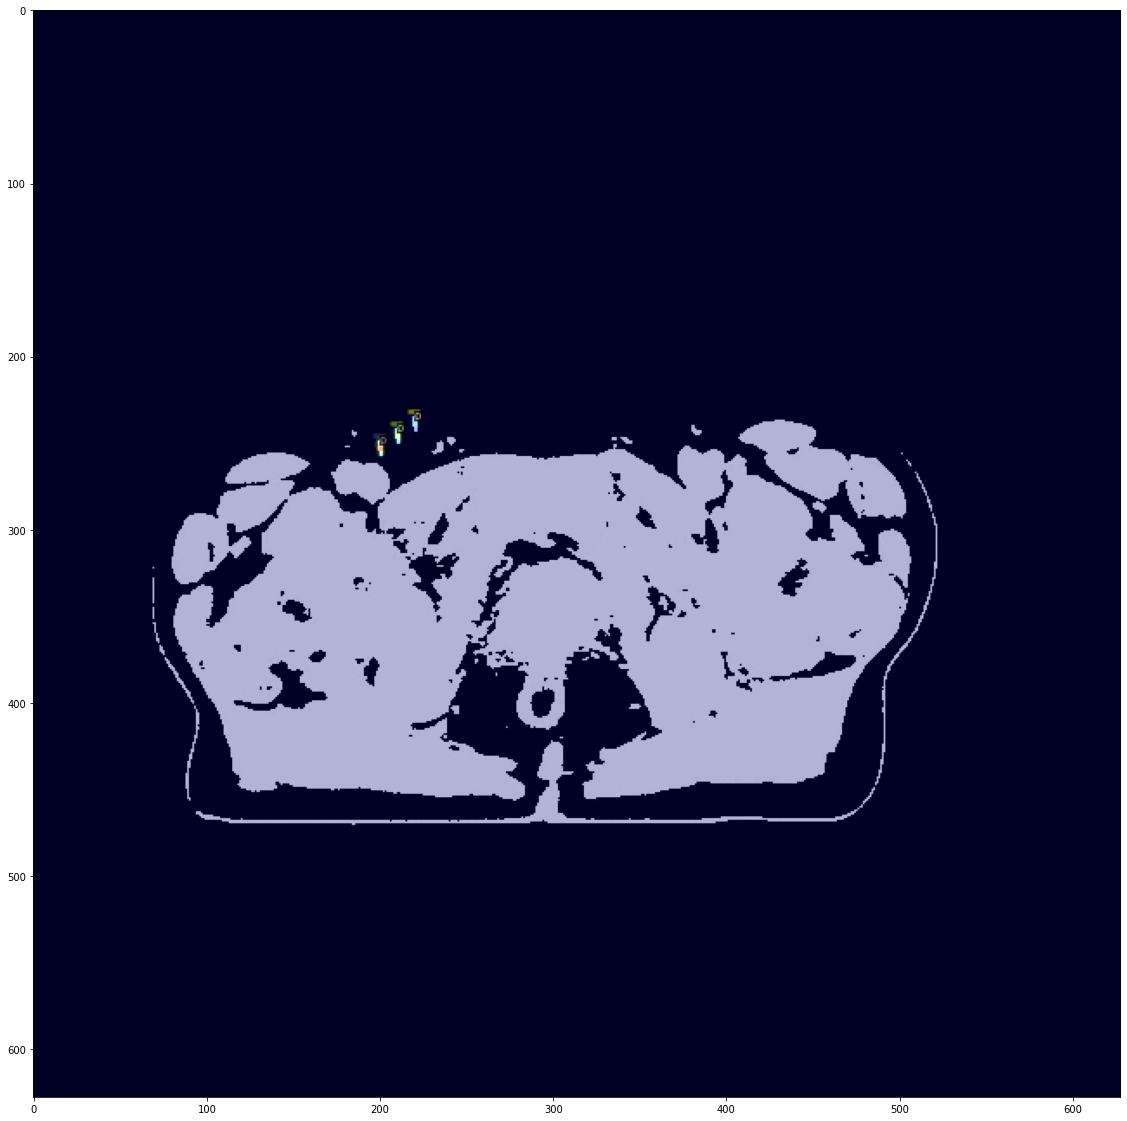

[{'bbox': [586, 425, 600, 425], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [600, 443, 614, 443], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [614, 461, 628, 461], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [628, 479, 642, 479], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [519, 614, 531, 614], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [535, 634, 547, 634], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [551, 654, 563, 654], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [567, 674, 579, 674], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]


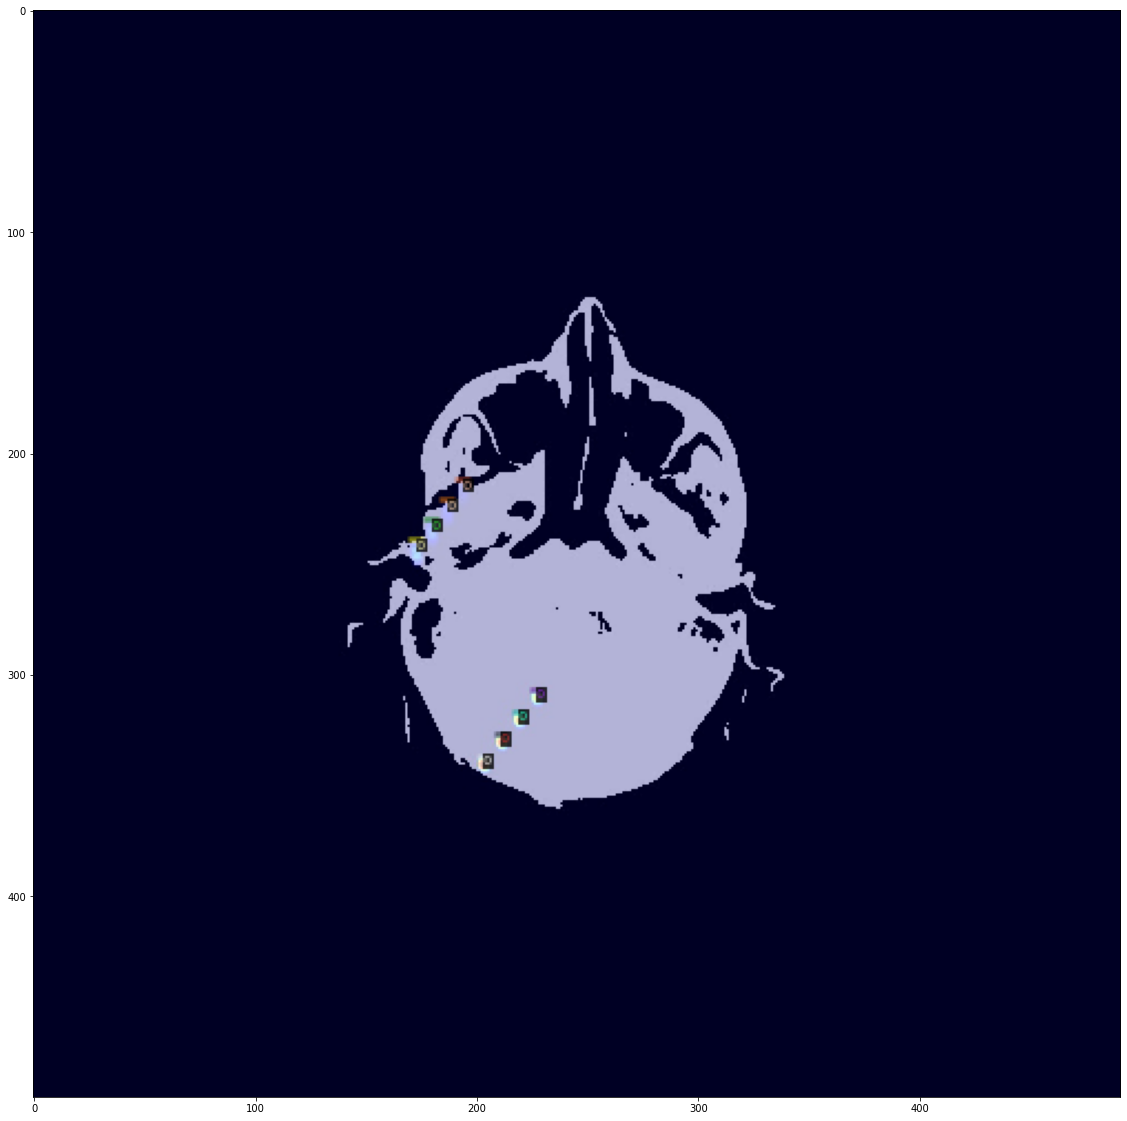

[{'bbox': [276, 528, 288, 528], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [291, 544, 303, 544], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [306, 560, 318, 560], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [321, 576, 333, 576], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [336, 592, 348, 592], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [406, 413, 437, 413], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [407, 415, 427, 415], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [423, 426, 454, 426], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [424, 428, 444, 428], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [440, 439, 471, 439], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [441, 441, 462, 441], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]


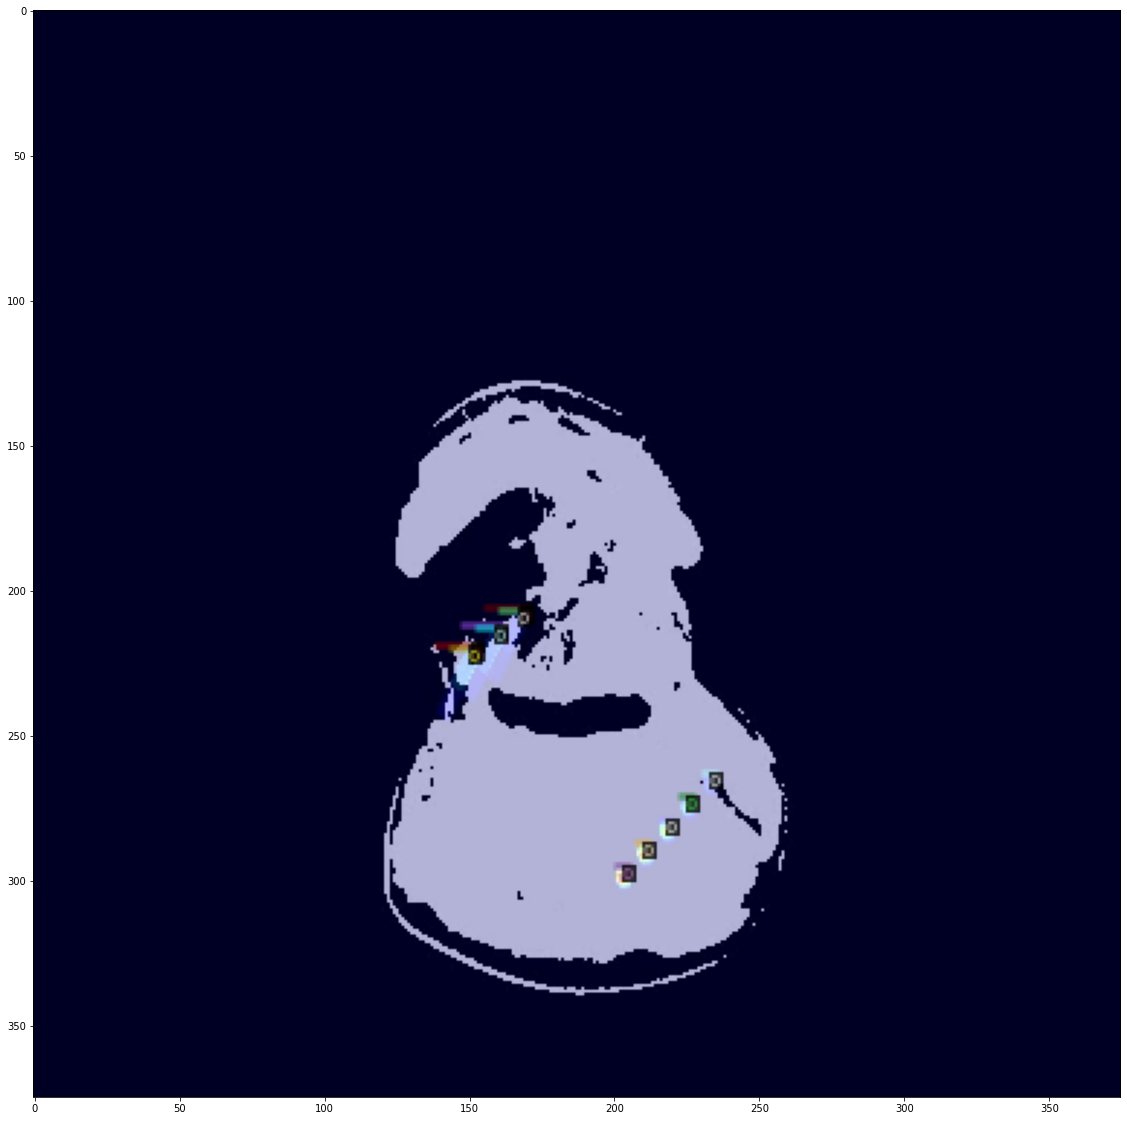

In [12]:
dataset_dicts=get_data_dict(val_df)
for item in random.sample(dataset_dicts,3):
    img=cv2.imread(item["file_name"])
    print (item["annotations"])
    visualizer = Visualizer(img[:, :,  ::-1], metadata=seed_metadata, scale=0.5)
    out=visualizer.draw_dataset_dict(item)
    plt.imshow(out.get_image()[: :, ::-1])
    plt.show()

In [13]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Misc/scratch_mask_rcnn_R_50_FPN_3x_gn.yaml"))
cfg.DATASETS.TRAIN = ("seed_train",)
cfg.MODEL.MASK_ON=False
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/scratch_mask_rcnn_R_50_FPN_3x_gn.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/08 08:31:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(
      256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_lateral3): Conv2d(
      512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output3): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_lateral4): Conv2d(
      1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output4): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): Group

  0%|          | 0/303 [00:00<?, ?it/s]

[08/08 08:31:33 d2.data.build]: Removed 0 images with no usable annotations. 303 images left.
[08/08 08:31:34 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    SEED    | 3300         |
|            |              |
[08/08 08:31:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/08 08:31:34 d2.data.build]: Using training sampler TrainingSampler
[08/08 08:31:34 d2.data.common]: Serializing 303 elements to byte tensors and concatenating them all ...
[08/08 08:31:34 d2.data.common]: Serialized dataset takes 0.19 MiB


model_final_01ca85.pkl: 183MB [00:31, 5.81MB/s]                           


[08/08 08:32:12 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[08/08 08:32:34 d2.utils.events]:  eta: 0:49:02  iter: 19  total_loss: 0.6477  loss_cls: 0.6348  loss_box_reg: 0  loss_rpn_cls: 0.0138  loss_rpn_loc: 0  time: 0.9777  data_time: 0.0261  lr: 4.9953e-06  max_mem: 7422M
[08/08 08:32:54 d2.utils.events]:  eta: 0:49:28  iter: 39  total_loss: 0.5321  loss_cls: 0.5201  loss_box_reg: 0  loss_rpn_cls: 0.01101  loss_rpn_loc: 0  time: 0.9904  data_time: 0.0084  lr: 9.9902e-06  max_mem: 7422M
[08/08 08:33:13 d2.utils.events]:  eta: 0:48:55  iter: 59  total_loss: 0.3491  loss_cls: 0.3452  loss_box_reg: 0  loss_rpn_cls: 0.009304  loss_rpn_loc: 0  time: 0.9856  data_time: 0.0074  lr: 1.4985e-05  max_mem: 7422M
[08/08 08:33:34 d2.utils.events]:  eta: 0:48:42  iter: 79  total_loss: 0.2369  loss_cls: 0.2243  loss_box_reg: 0  loss_rpn_cls: 0.008048  loss_rpn_loc: 0  time: 0.9947  data_time: 0.0122  lr: 1.998e-05  max_mem: 7422M
[08/08 08:33:54 d2.utils.events]:  eta: 0:48:38  iter: 99  total_loss: 0.142  loss_cls: 0.1327  loss_box_reg: 0  loss_rpn_cls: 0